Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
# install necessary dependencies
%pip install -r requirements.txt

  Cloning https://github.com/google/trajax to /tmp/pip-req-build-687d6d6r
  Running command git clone --filter=blob:none --quiet https://github.com/google/trajax /tmp/pip-req-build-687d6d6r
  Resolved https://github.com/google/trajax to commit c94a637c5a397b3d4100153f25b4b165507b5b20
  Installing build dependencies ...   Resolved https://github.com/google/trajax to commit c94a637c5a397b3d4100153f25b4b165507b5b20
  Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... -done
  Preparing metadata (pyproject.toml) ... one
  Preparing metadata (pyproject.toml) ... done
done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# from jax.config import config
import sys
from pathlib import Path

# Ensure the local Trajax package is importable before third-party installs
repo_root = Path().resolve().parents[1]
repo_root_str = str(repo_root)
if repo_root_str in sys.path:
    sys.path.remove(repo_root_str)
sys.path.insert(0, repo_root_str)

from absl import logging
logging.set_verbosity(logging.INFO)

import jax
jax.config.update('jax_enable_x64', True)

import jax.numpy as jnp

import matplotlib
import matplotlib.pyplot as plt

from importlib import reload

In [3]:
import importlib
import sys

# Drop previously imported Trajax modules so local edits take effect
for _mod in list(sys.modules):
    if _mod.startswith("trajax"):
        sys.modules.pop(_mod)

from trajax import integrators
from trajax.experimental.sqp import shootsqp, util

In [4]:
from trajax.experimental.sqp import solver_base
reload(solver_base)
reload(shootsqp)
reload(util)

<module 'trajax.experimental.sqp.util' from '/home/andrea-ostuni/jax_ws/trajax/trajax/experimental/sqp/util.py'>

# Define Problem

## Setup Obstacle environment

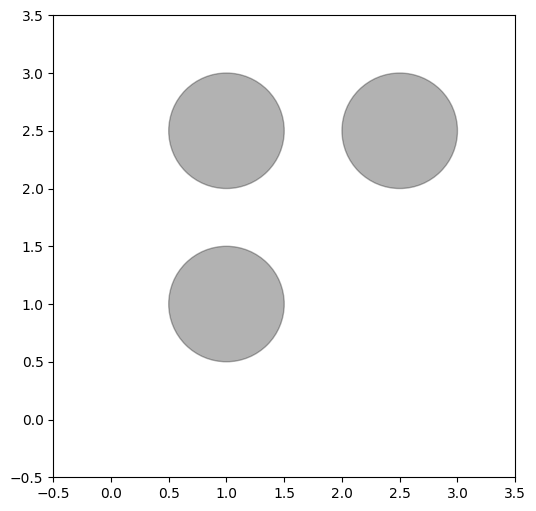

In [5]:
# @title {vertical-output: true}

obs = [(jnp.array([1., 1.]), 0.5),
          (jnp.array([1, 2.5]), 0.5),
          (jnp.array([2.5, 2.5]), 0.5)]

def render_scene():
  # Setup obstacle environment for state constraint
  world_range = (jnp.array([-0.5, -0.5]), jnp.array([3.5, 3.5]))

  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  plt.grid(False)

  for ob in obs:
    ax.add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.3))
  ax.set_xlim([world_range[0][0], world_range[1][0]])
  ax.set_ylim([world_range[0][1], world_range[1][1]])

  ax.set_aspect('equal')
  return fig, ax

_ = render_scene()

## Setup Dynamics, cost, constraints

In [6]:
# Setup discrete-time dynamics
def car_ode(x, u, t):
  del t
  return jnp.array([x[3] * jnp.sin(x[2]),
                    x[3] * jnp.cos(x[2]),
                    x[3] * u[0],
                    u[1]])
dt = 0.05
dynamics = integrators.euler(car_ode, dt=dt)

# Constants
n, m, T = (4, 2, 40)

# Indices of state corresponding to S1 sphere constraints
s1_indices = (2,)
state_wrap = util.get_s1_wrapper(s1_indices)


# Cost function.
R = jnp.diag(jnp.array([0.2, 0.1]))
Q_T = jnp.diag(jnp.array([50., 50., 50., 10.]))
goal_default = jnp.array([3., 3., jnp.pi/2, 0.])

@jax.jit
def cost(x, u, t, goal=goal_default):
  stage_cost = dt * jnp.vdot(u, R @ u)
  delta = state_wrap(x - goal)
  term_cost = jnp.vdot(delta, Q_T @ delta)
  return jnp.where(t == T, term_cost, stage_cost)

# Control box bounds
control_bounds = (jnp.array([-jnp.pi/3., -6.]),
                  jnp.array([jnp.pi/3., 6.]))

# Obstacle avoidance constraint function
def obs_constraint(pos):
  def avoid_obs(pos_c, ob):
    delta_body = pos_c - ob[0]
    delta_dist_sq = jnp.vdot(delta_body, delta_body) - (ob[1]**2)
    return delta_dist_sq
  return jnp.array([avoid_obs(pos, ob) for ob in obs])

# State constraint function
@jax.jit
def state_constraint(x, t):
  del t
  pos = x[0:2]
  return obs_constraint(pos)

# Define Solver

In [7]:
# Define Solver
solver_options = dict(method=shootsqp.SQP_METHOD.OPEN,
                      hess="full", verbose=True, debug=True,
                      qp_solver=shootsqp.QP_SOLVER.QP_ALILQR,
                      max_iter=100, ls_eta=0.49, ls_beta=0.8,
                      primal_tol=1e-3, dual_tol=1e-3, stall_check="abs")
solver = shootsqp.ShootSQP(n, m, T, dynamics, cost, control_bounds,
                           state_constraint, s1_ind=s1_indices, **solver_options)

In [8]:
# Variations to try:
# method={OPEN, SENS}
# proj_init={FALSE, TRUE}

# Solve

## Set initial conditions and guess

In [9]:
# Set initial conditions and problem parameters
# x0 = jnp.zeros((n,))
# x0 = jnp.array([0.25, 1.75, 0., 0.])
x0 = jnp.array([1.75, 1.0, 0., 0.])
U0 = jnp.zeros((T, m))
X0 = None
solver.opt.proj_init = False

In [10]:
import numpy as np

solver.opt.proj_init = True

# Build a collision-free waypoint path that skirts the right-hand obstacles
waypoints = np.array([
    np.array(x0[:2]),
    np.array([2.4, 1.0]),
    np.array([2.8, 2.2]),
    np.array(goal_default[:2])
], dtype=float)

# Allocate samples per segment (sums to T+1 overall)
n1 = 14
n2 = 14
n3 = (T + 1) - (n1 + n2)
if n3 < 3:
    raise ValueError("Segment allocation produced too few samples; adjust counts.")

positions = np.vstack([
    np.linspace(waypoints[0], waypoints[1], n1, endpoint=False),
    np.linspace(waypoints[1], waypoints[2], n2, endpoint=False),
    np.linspace(waypoints[2], waypoints[3], n3, endpoint=True)
])

# Derive heading (theta) and speed columns for the initial state roll-out
deltas = np.diff(positions, axis=0, prepend=positions[:1])
heading = np.arctan2(deltas[:, 0], deltas[:, 1])
speed = np.linalg.norm(deltas, axis=1) / dt
speed[0] = 0.0

X0 = jnp.column_stack((jnp.array(positions), jnp.array(heading), jnp.array(speed)))

In [11]:
# Quick sanity check for obstacle clearance of X0 positions
min_clearance = jnp.min(obs_constraint(X0[:, :2]))
print('Minimum obstacle clearance in X0:', float(min_clearance))

Minimum obstacle clearance in X0: 52.028105158730156


## Solve

In [12]:
# Run for one iteration to jit first
solver.opt.max_iter = 1
_ = solver.solve(x0, U0, X0)

{'cslack': (Array(0., dtype=float64), Array(0., dtype=float64)), 'dual': (Array(0., dtype=float64), Array(0., dtype=float64)), 'obj': Array(107.14838223, dtype=float64), 'primal': (Array(0., dtype=float64), Array(-0.20413013, dtype=float64)), 'stat': Array(11.91361567, dtype=float64)}
phi(0):107.14838222822372, phi_g(0):-33.33066705731693
phi(0):107.14838222822372, phi_g(0):-33.33066705731693
SOLVE: it: 1, obj: 58.833353380306306, |dU|: 2.826927168489367, step-length: 0.423635533307517, rho: 1660.4884973994415
Status: MAXITER, obj: 58.833353380306306
SOLVE: it: 1, obj: 58.833353380306306, |dU|: 2.826927168489367, step-length: 0.423635533307517, rho: 1660.4884973994415
Status: MAXITER, obj: 58.833353380306306


In [13]:
# Run to completion
solver.opt.max_iter = 100
soln = solver.solve(x0, U0, X0)

{'cslack': (Array(0., dtype=float64), Array(0., dtype=float64)), 'dual': (Array(0., dtype=float64), Array(0., dtype=float64)), 'obj': Array(107.14838223, dtype=float64), 'primal': (Array(0., dtype=float64), Array(-0.20413013, dtype=float64)), 'stat': Array(11.91361567, dtype=float64)}
phi(0):107.14838222822372, phi_g(0):-33.33066705731693
SOLVE: it: 1, obj: 58.833353380306306, |dU|: 2.826927168489367, step-length: 0.423635533307517, rho: 1660.4884973994415
{'cslack': (Array(0.78050823, dtype=float64), Array(15.04210964, dtype=float64)), 'dual': (Array(0., dtype=float64), Array(0., dtype=float64)), 'obj': Array(58.83335338, dtype=float64), 'primal': (Array(-5.01233699e-09, dtype=float64), Array(-0.10121196, dtype=float64)), 'stat': Array(12.06173737, dtype=float64)}
phi(0):107.14838222822372, phi_g(0):-33.33066705731693
SOLVE: it: 1, obj: 58.833353380306306, |dU|: 2.826927168489367, step-length: 0.423635533307517, rho: 1660.4884973994415
{'cslack': (Array(0.78050823, dtype=float64), Arr

In [14]:
print(soln.iterations, soln.objective)
soln.kkt_residuals

6 24.62777324996096


{'cslack': (Array(3.77331586e-06, dtype=float64),
  Array(0.03171088, dtype=float64)),
 'dual': (Array(0., dtype=float64), Array(0., dtype=float64)),
 'obj': Array(24.62777325, dtype=float64),
 'primal': (Array(-1.14139627e-07, dtype=float64),
  Array(0.00026325, dtype=float64)),
 'stat': Array(0.10944047, dtype=float64)}

In [15]:
print('status:', soln.status)
print('message:', getattr(soln, 'status_message', 'n/a'))
print('iterations:', soln.iterations)
for key, val in soln.history.items():
    vals = jnp.asarray(list(val)) if len(val) else jnp.asarray([])
    print(key, vals.shape, 'head:', vals[:min(3, vals.shape[0])])

status: Status.SOLVED
message: n/a
iterations: 6
steplength (6,) head: [0.42363553 1.         1.        ]
obj (6,) head: [58.83335338 33.85173899 25.35049979]
min_viol (6,) head: [-0.10121196  0.01463423 -0.00115957]


In [16]:
print('soln fields:', sorted(soln.__dict__.keys()))

soln fields: ['duals', 'history', 'iterations', 'kkt_residuals', 'objective', 'primals', 'status', 'times']


# Plot solution

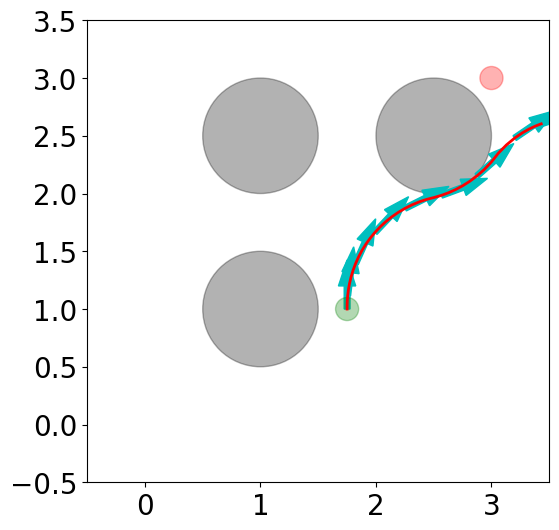

In [17]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = render_scene()
U, X = soln.primals
ax.plot(X[:, 0], X[:, 1], 'r-', linewidth=2)

for t in jnp.arange(0, solver._T+1, 5):
  ax.arrow(X[t, 0], X[t, 1],
      0.2 * jnp.sin(X[t, 2]), 0.2 * jnp.cos(X[t, 2]),
      width=0.05, color='c')

# Start
ax.add_patch(plt.Circle([x0[0], x0[1]], 0.1, color='g', alpha=0.3))
# End
ax.add_patch(plt.Circle([goal_default[0], goal_default[1]], 0.1, color='r', alpha=0.3))

ax.set_aspect('equal')

Text(0.5, 0, 'Time [s]')

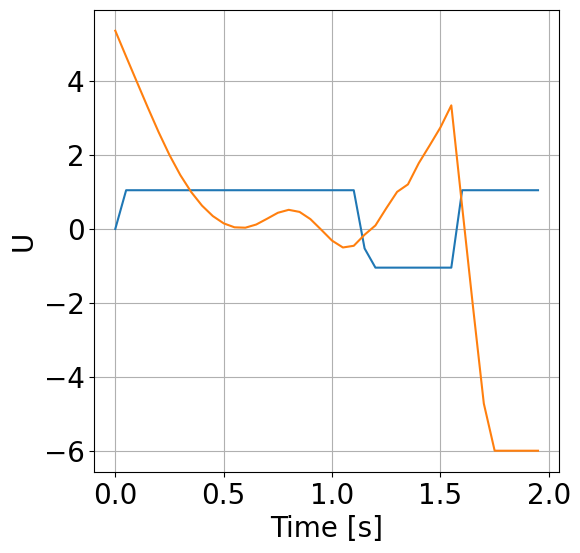

In [18]:
# @title {vertical-output: true}
%matplotlib inline

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(True)
plt.plot(solver._timesteps[:-1]*dt, U, markersize=5)
ax.set_ylabel('U')
ax.set_xlabel('Time [s]')


# Plot solver progress

In [19]:
import seaborn as sns
colors = sns.color_palette("tab10")

In [20]:
history = soln.history
history.keys()

dict_keys(['steplength', 'obj', 'min_viol'])

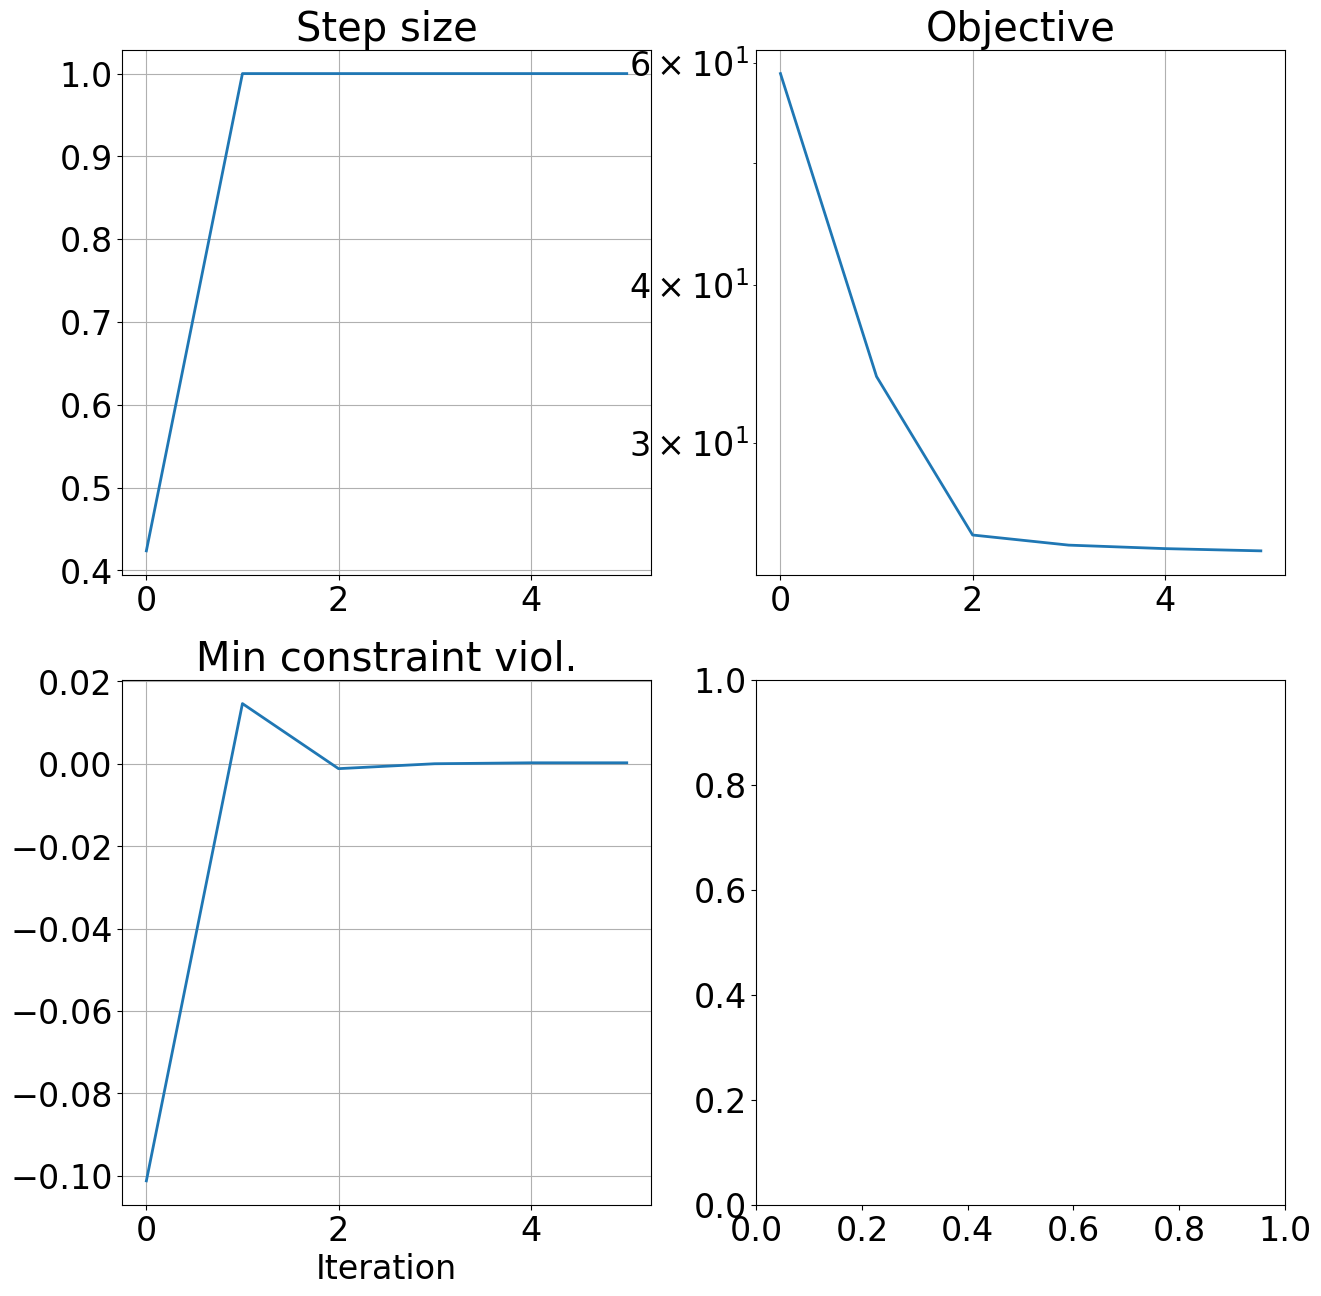

In [21]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 24})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].plot(history['steplength'], color=colors[0], linewidth=2)
axs[0][0].set_title('Step size')
axs[0][0].grid(True)

axs[0][1].plot(history['obj'], color=colors[0], linewidth=2)
axs[0][1].set_title('Objective')
axs[0][1].set_yscale('log')
axs[0][1].grid(True)

axs[1][0].plot(history['min_viol'], color=colors[0], linewidth=2)
axs[1][0].set_title('Min constraint viol.')
axs[1][0].set_xlabel('Iteration')
axs[1][0].grid(True)

if 'ddp_err' in history:
  axs[1][1].plot(history['ddp_err'], color=colors[0], linewidth=2)
  axs2 = axs[1][1].twinx()
  axs2.plot(history['ddp_err_grad'], color=colors[1], linewidth=2)
  axs2.set_yscale("log")
  axs[1][1].set_title('DDP errors')
  axs[1][1].set_xlabel('Iteration')
  axs[1][1].grid(True)

In [22]:
import pandas as pd
import time
import resource
from collections import OrderedDict

def run_with_method(method):
    """Solve the SQP problem with a specified rollout method."""
    solver = shootsqp.ShootSQP(
        n,
        m,
        T,
        dynamics,
        cost,
        control_bounds,
        state_constraint,
        s1_ind=s1_indices,
        method=method,
        hess="full",
        verbose=False,
        debug=False,
        qp_solver=shootsqp.QP_SOLVER.QP_ALILQR,
        max_iter=120,
        ls_eta=0.49,
        ls_beta=0.8,
        primal_tol=1e-3,
        dual_tol=1e-3,
        stall_check="abs",
        ddp_options={'ddp_gamma': 1e-4},
    )
    solver.opt.proj_init = True
    stats = OrderedDict(method=method.name)
    start_time = time.perf_counter()
    rss_before = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    try:
        sol = solver.solve(x0, U0, X0)
    except Exception as exc:
        elapsed = time.perf_counter() - start_time
        rss_after = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
        peak_delta_mb = max(0.0, (rss_after - rss_before) / 1024.0)
        stats.update(status="EXCEPTION", iterations=jnp.nan, objective=jnp.nan,
                    total_time=elapsed, peak_mem_mb=peak_delta_mb, notes=str(exc))
        return stats, None
    elapsed = time.perf_counter() - start_time
    rss_after = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    peak_delta_mb = max(0.0, (rss_after - rss_before) / 1024.0)
    history = {k: list(v) for k, v in (sol.history or {}).items()}
    stats.update(
        status=sol.status.name,
        iterations=int(sol.iterations),
        objective=float(sol.objective),
        min_primal=float(jnp.min(jnp.asarray(sol.kkt_residuals["primal"]))),
        max_stat=float(sol.kkt_residuals["stat"]),
        final_min_viol=float(history.get("min_viol", [jnp.nan])[-1]),
        step_length_first=float(history.get("steplength", [jnp.nan])[0]),
        step_length_last=float(history.get("steplength", [jnp.nan])[-1]),
        total_time=elapsed,
        peak_mem_mb=peak_delta_mb,
    )
    return stats, sol

solver_methods = [
    shootsqp.SQP_METHOD.OPEN,
    shootsqp.SQP_METHOD.STABLE,
    shootsqp.SQP_METHOD.SENS,
    shootsqp.SQP_METHOD.APPROX_SENS,
    # shootsqp.SQP_METHOD.APPROX_SENS may coincide with SENS but included for completeness
 ]

comparison_rows = []
solution_bank = {}
for method in solver_methods:
    stats, solution = run_with_method(method)
    comparison_rows.append(stats)
    if solution is not None:
        solution_bank[method.name] = solution
comparison_df = pd.DataFrame(comparison_rows)
comparison_df

,method,status,iterations,objective,min_primal,max_stat,final_min_viol,step_length_first,step_length_last,total_time,peak_mem_mb
0,OPEN,SOLVED,6,24.627773,-1.141396e-07,0.109440,0.000263,0.423636,1.000000,11.207983,90.054688
1,STABLE,STALLED,5,26.117357,-1.630770e-04,21.685535,-0.000163,0.409600,0.000009,11.968390,113.375000
2,SENS,SOLVED,16,24.230576,0.000000e+00,0.089713,0.000014,0.085899,1.000000,30.144504,156.667969
3,APPROX_SENS,SOLVED,77,24.429727,-2.915142e-04,0.116930,-0.000292,0.022518,0.077892,93.909758,127.792969


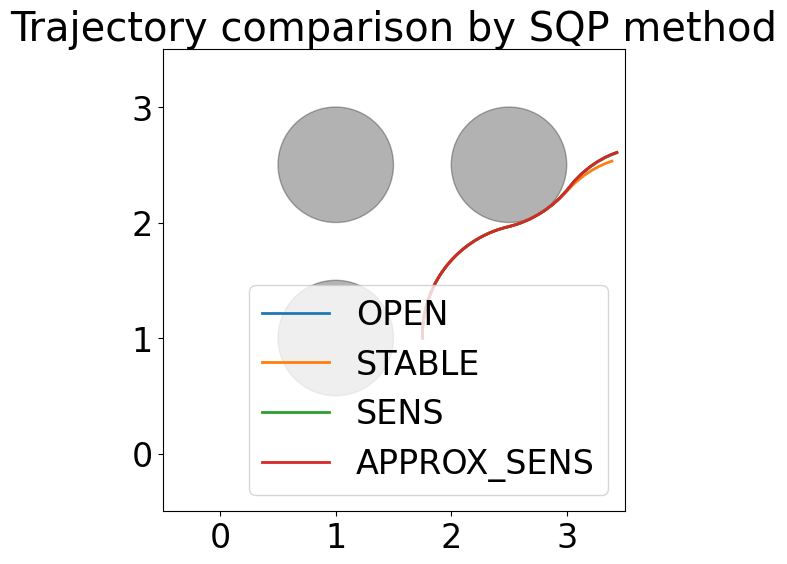

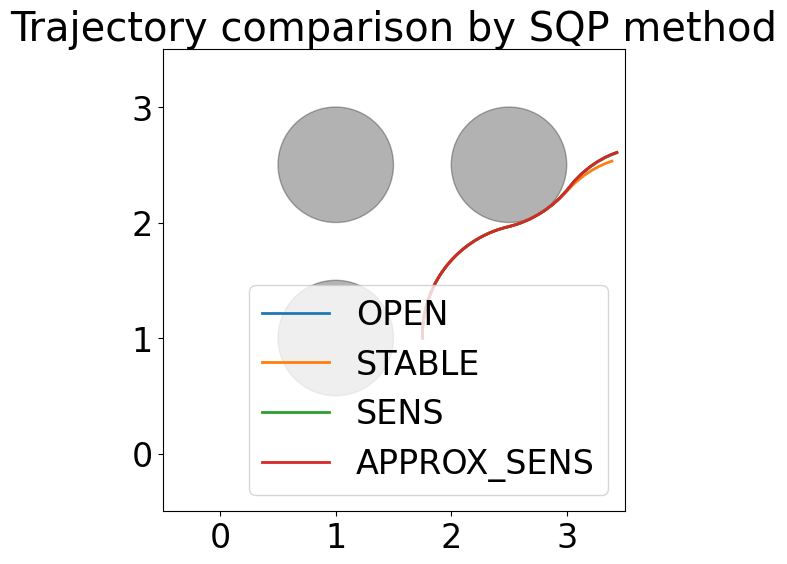

In [23]:
fig, ax = render_scene()
for method_name, solution in solution_bank.items():
    U_sol, X_sol = solution.primals
    ax.plot(np.array(X_sol)[:, 0], np.array(X_sol)[:, 1], linewidth=2, label=method_name)
ax.set_title("Trajectory comparison by SQP method")
ax.legend(loc="lower right")
fig

In [24]:
qp_solvers = [
    shootsqp.QP_SOLVER.QP_ALILQR,
    shootsqp.QP_SOLVER.QP_ECOS,
    shootsqp.QP_SOLVER.QP_CVX
 ]

qp_rows = []
qp_solution_bank = {}
for qp_solver in qp_solvers:
    solver = shootsqp.ShootSQP(
        n, m, T, dynamics, cost, control_bounds, state_constraint,
        s1_ind=s1_indices,
        method=shootsqp.SQP_METHOD.OPEN,
        hess="full",
        verbose=False,
        debug=False,
        qp_solver=qp_solver,
        max_iter=120,
        ls_eta=0.49,
        ls_beta=0.8,
        primal_tol=1e-3,
        dual_tol=1e-3,
        stall_check="abs",
    )
    solver.opt.proj_init = True
    stats = OrderedDict(qp_solver=qp_solver.value)
    start_time = time.perf_counter()
    rss_before = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    try:
        sol = solver.solve(x0, U0, X0)
    except Exception as exc:
        elapsed = time.perf_counter() - start_time
        rss_after = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
        peak_delta_mb = max(0.0, (rss_after - rss_before) / 1024.0)
        stats.update(status="EXCEPTION", iterations=jnp.nan, objective=jnp.nan,
                    total_time=elapsed, peak_mem_mb=peak_delta_mb, notes=str(exc))
        qp_rows.append(stats)
        continue
    elapsed = time.perf_counter() - start_time
    rss_after = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    peak_delta_mb = max(0.0, (rss_after - rss_before) / 1024.0)
    stats.update(
        status=sol.status.name,
        iterations=int(sol.iterations),
        objective=float(sol.objective),
        min_primal=float(jnp.min(jnp.asarray(sol.kkt_residuals["primal"]))),
        max_stat=float(sol.kkt_residuals["stat"]),
        total_time=elapsed,
        peak_mem_mb=peak_delta_mb,
    )
    qp_rows.append(stats)
    qp_solution_bank[qp_solver.value] = sol
qp_comparison_df = pd.DataFrame(qp_rows)
qp_comparison_df

/home/andrea-ostuni/jax_ws/.venv_jax/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


,qp_solver,status,iterations,objective,min_primal,max_stat,total_time,peak_mem_mb
0,alilqr,SOLVED,6,24.627773,-1.141396e-07,0.109440,11.318750,71.207031
1,ecos,SOLVED,9,23.979914,-3.741452e-13,0.139788,5.940707,81.335938
2,cvxopt,SOLVED,9,23.979914,-2.560285e-11,0.139793,7.129692,61.062500
